In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.18.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_df.head()

,Text,Score
0,I just recently have gone gluten free and miss...,4
1,I had been eying the Popchips brand for some t...,2
2,"Over the last year our so, we've discovered th...",5
3,I'm sorry. It must be that the bacon was almos...,1
4,I'm not a huge fan of spicy foods but I love t...,2


In [ ]:
# Tokenize the input
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.Text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 66153


In [ ]:
# Pad long sequences for model use
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_df.Text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_df.Text), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (119076, 30)
Testing X Shape: (29769, 30)


In [ ]:
# Format the target feature to work properly with the model
encoder = LabelEncoder()
encoder.fit(train_df.Score.to_list())

y_train = encoder.transform(train_df.Score.to_list())
y_test = encoder.transform(test_df.Score.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

y_train shape: (119076, 1)
y_test shape: (29769, 1)


In [ ]:
# GloVE available at http://nlp.stanford.edu/data/glove.6B.zip
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Initializing embedding matrix with GloVe data
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Apply all layers to the model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(5, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                      patience=3,
                                     min_lr = 0.0001,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [25]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.3038 - loss: 1.5036 - val_accuracy: 0.4544 - val_loss: 1.2589 - learning_rate: 0.0010
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.4566 - loss: 1.2539 - val_accuracy: 0.4934 - val_loss: 1.1932 - learning_rate: 0.0010
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5031 - loss: 1.1608 - val_accuracy: 0.5207 - val_loss: 1.1511 - learning_rate: 0.0010
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5469 - loss: 1.0839 - val_accuracy: 0.5384 - val_loss: 1.1224 - learning_rate: 0.0010
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5799 - loss: 1.0168 - val_accuracy: 0.5476 - val_loss: 1.1075 - learning_rate: 0.0010
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.6128 - loss: 0.9450 - val_accuracy: 0.5604 - val_loss: 1.1010 - learning_rate: 0.0010
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.6469 - loss: 0.

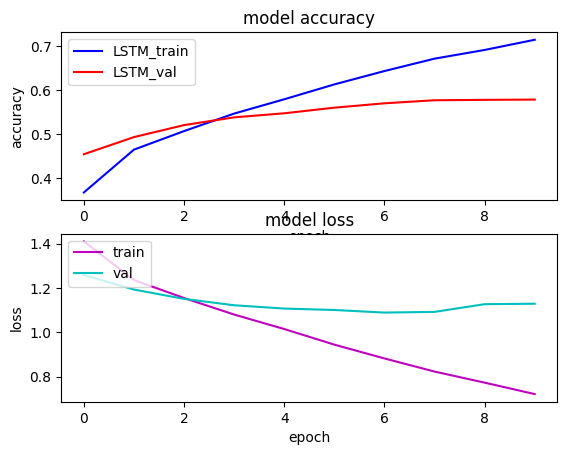

In [26]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
